In [1]:
# !pip3 install s3fs --user

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline
# plt.style.use('seaborn-whitegrid')

In [3]:
import findspark
findspark.init()

In [4]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-10-20 13:08:46,440 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2022-10-20 13:08:49,765 WARN yarn.Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [5]:
# 데이터를 hdfs에서 가지고 옴
train_data = spark.read.csv("hdfs:///user/ubuntu/dataym/2009/02/02.csv", )
test_data = spark.read.option("header",True).csv("hdfs:///user/data/test.csv")

In [6]:
train_data.show(5)

+--------------------+----+--------------------+----------+---------+----------+---------+---+
|                 _c0| _c1|                 _c2|       _c3|      _c4|       _c5|      _c6|_c7|
+--------------------+----+--------------------+----------+---------+----------+---------+---+
|2009-02-27 13:31:...|16.5|2009-02-27 13:31:...|-73.974938|40.762091|-74.003309|40.706195|  2|
|2009-02-13 16:54:...| 6.7|2009-02-13 16:54:...|-73.959669|40.779718|-73.976259|40.788413|  1|
|2009-02-22 22:48:...| 2.5|2009-02-22 22:48:...|         0|        0|-74.005433|40.726685|  2|
|2009-02-16 07:40:...|14.5|2009-02-16 07:40:...|-73.948872|40.807601|-73.937218|40.767366|  1|
|2009-02-27 17:39:...| 8.1|2009-02-27 17:39:...|-73.992877|40.742668|-73.983468| 40.74748|  1|
+--------------------+----+--------------------+----------+---------+----------+---------+---+
only showing top 5 rows



In [7]:
test_data.show(3)

+--------------------+--------------------+-------------------+------------------+-------------------+------------------+---------------+
|                 key|     pickup_datetime|   pickup_longitude|   pickup_latitude|  dropoff_longitude|  dropoff_latitude|passenger_count|
+--------------------+--------------------+-------------------+------------------+-------------------+------------------+---------------+
|2015-01-27 13:08:...|2015-01-27 13:08:...|-73.973320007324219|  40.7638053894043|-73.981430053710938| 40.74383544921875|              1|
|2015-01-27 13:08:...|2015-01-27 13:08:...|-73.986862182617188|40.719383239746094|-73.998886108398438|40.739200592041016|              1|
|2011-10-08 11:53:...|2011-10-08 11:53:...|         -73.982524|          40.75126|         -73.979654|         40.746139|              1|
+--------------------+--------------------+-------------------+------------------+-------------------+------------------+---------------+
only showing top 3 rows



In [8]:
# train_data가 너무 크니 10000개로 자르기
little_train_data = train_data.limit(10000)

In [9]:
# pyspark.sql.dataframe.DataFrame to Pandas df
df_train = little_train_data.toPandas()
df_test = test_data.toPandas()
display(df_train.head(2))
df_test.head(2)

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7
0,2009-02-27 13:31:21.0000003,16.5,2009-02-27 13:31:21 UTC,-73.974938,40.762091,-74.003309,40.706195,2
1,2009-02-13 16:54:52.0000006,6.7,2009-02-13 16:54:52 UTC,-73.959669,40.779718,-73.976259,40.788413,1


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320007324219,40.7638053894043,-73.981430053710938,40.74383544921875,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862182617188,40.719383239746094,-73.998886108398438,40.739200592041016,1


In [10]:
train_column_list =  ["key","fare_amount","pickup_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count"]
test_column_list = ["key","pickup_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count"]

In [11]:
df_train.columns = train_column_list
df_test.columns = test_column_list

In [12]:
display(df_train.head(2))
df_test.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-02-27 13:31:21.0000003,16.5,2009-02-27 13:31:21 UTC,-73.974938,40.762091,-74.003309,40.706195,2
1,2009-02-13 16:54:52.0000006,6.7,2009-02-13 16:54:52 UTC,-73.959669,40.779718,-73.976259,40.788413,1


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320007324219,40.7638053894043,-73.981430053710938,40.74383544921875,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862182617188,40.719383239746094,-73.998886108398438,40.739200592041016,1


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   key                10000 non-null  object
 1   fare_amount        10000 non-null  object
 2   pickup_datetime    10000 non-null  object
 3   pickup_longitude   10000 non-null  object
 4   pickup_latitude    10000 non-null  object
 5   dropoff_longitude  10000 non-null  object
 6   dropoff_latitude   10000 non-null  object
 7   passenger_count    10000 non-null  object
dtypes: object(8)
memory usage: 625.1+ KB


In [14]:
# df_train['key'] = pd.to_datetime(df_train['key'])
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])
# df_test['key'] = pd.to_datetime(df_test['key'])
df_test['pickup_datetime']  = pd.to_datetime(df_test['pickup_datetime'])

In [15]:
# Dtype이 object를 float,int로 변경
df_train = df_train.astype({'fare_amount':'float',
              'pickup_longitude':'float',
              'pickup_latitude':'float',
              'dropoff_longitude':'float',
              'dropoff_latitude':'float',
              'passenger_count':'int'},)
df_test = df_test.astype({'pickup_longitude':'float',
              'pickup_latitude':'float',
              'dropoff_longitude':'float',
              'dropoff_latitude':'float',
              'passenger_count':'int'},)

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                10000 non-null  object             
 1   fare_amount        10000 non-null  float64            
 2   pickup_datetime    10000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   10000 non-null  float64            
 4   pickup_latitude    10000 non-null  float64            
 5   dropoff_longitude  10000 non-null  float64            
 6   dropoff_latitude   10000 non-null  float64            
 7   passenger_count    10000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 625.1+ KB


In [17]:
df_test.head(2)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1


In [18]:
df_train.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-02-27 13:31:21.0000003,16.5,2009-02-27 13:31:21+00:00,-73.974938,40.762091,-74.003309,40.706195,2
1,2009-02-13 16:54:52.0000006,6.7,2009-02-13 16:54:52+00:00,-73.959669,40.779718,-73.976259,40.788413,1


In [19]:
# pickup_datetime에서 UTC 빼는 방법
df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime).dt.tz_localize(None)
df_test['pickup_datetime'] = pd.to_datetime(df_test.pickup_datetime).dt.tz_localize(None)

In [20]:
df_train.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-02-27 13:31:21.0000003,16.5,2009-02-27 13:31:21,-73.974938,40.762091,-74.003309,40.706195,2
1,2009-02-13 16:54:52.0000006,6.7,2009-02-13 16:54:52,-73.959669,40.779718,-73.976259,40.788413,1


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                10000 non-null  object        
 1   fare_amount        10000 non-null  float64       
 2   pickup_datetime    10000 non-null  datetime64[ns]
 3   pickup_longitude   10000 non-null  float64       
 4   pickup_latitude    10000 non-null  float64       
 5   dropoff_longitude  10000 non-null  float64       
 6   dropoff_latitude   10000 non-null  float64       
 7   passenger_count    10000 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 625.1+ KB


In [22]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,9.766464,-72.836445,40.124690,-72.857297,40.137205,1.698500
std,7.641671,9.109876,5.018559,9.021908,4.970237,1.283496
min,2.500000,-78.725186,0.000000,-78.725186,0.000000,1.000000
25%,5.700000,-73.991737,40.735857,-73.991061,40.734826,1.000000
50%,7.700000,-73.981638,40.753253,-73.980051,40.753724,1.000000
75%,10.900000,-73.968195,40.768140,-73.964204,40.769034,2.000000
max,146.900000,0.000000,41.366138,0.000000,41.366138,6.000000


In [23]:
print('Old size: %d' % len(df_train))
df_train = df_train[df_train.fare_amount>=0]
print('New size: %d' % len(df_train))

Old size: 10000
New size: 10000


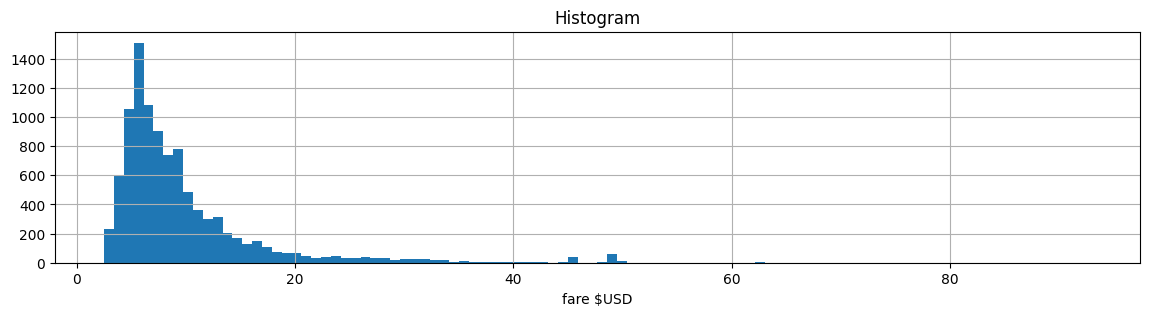

In [24]:
df_train[df_train.fare_amount<100].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

In [25]:
print(df_train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [26]:
print('Old size: %d' % len(df_train))
df_train = df_train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(df_train))

Old size: 10000
New size: 10000


In [27]:
# df_test =  pd.read_csv('../input/test.csv')
# df_test.head(5)

In [28]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


### Location data

In [29]:
# minimum and maximum longitude test set
min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()), \
max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max())

(-74.263242, -72.986532)

In [30]:
# minimum and maximum latitude test
min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()), \
max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())

(40.568973, 41.709555)

In [31]:
# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
# nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
# nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [32]:
print('Old size: %d' % len(df_train))
df_train = df_train[select_within_boundingbox(df_train, BB)]
print('New size: %d' % len(df_train))

Old size: 10000
New size: 9843


In [33]:
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    # return only datapoints on land
    return df[idx]

In [34]:
# print('Old size: %d' % len(df_train))
# df_train = remove_datapoints_from_water(df_train)
# print('New size: %d' % len(df_train))

In [35]:
# For this plot and further analysis, we need a function to calculate the distance in miles between locations in lon,lat coordinates.
# This function is based on https://stackoverflow.com/questions/27928/
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# return distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

# # First calculate two arrays with datapoint density per sq mile
# n_lon, n_lat = 200, 200 # number of grid bins per longitude, latitude dimension
# density_pickup, density_dropoff = np.zeros((n_lat, n_lon)), np.zeros((n_lat, n_lon)) # prepare arrays

# # To calculate the number of datapoints in a grid area, the numpy.digitize() function is used. 
# # This function needs an array with the (location) bins for counting the number of datapoints
# # per bin.
# bins_lon = np.zeros(n_lon+1) # bin
# bins_lat = np.zeros(n_lat+1) # bin
# delta_lon = (BB[1]-BB[0]) / n_lon # bin longutide width
# delta_lat = (BB[3]-BB[2]) / n_lat # bin latitude height
# bin_width_miles = distance(BB[2], BB[1], BB[2], BB[0]) / n_lon # bin width in miles
# bin_height_miles = distance(BB[3], BB[0], BB[2], BB[0]) / n_lat # bin height in miles
# for i in range(n_lon+1):
#     bins_lon[i] = BB[0] + i * delta_lon
# for j in range(n_lat+1):
#     bins_lat[j] = BB[2] + j * delta_lat
    
# # Digitize per longitude, latitude dimension
# inds_pickup_lon = np.digitize(df_train.pickup_longitude, bins_lon)
# inds_pickup_lat = np.digitize(df_train.pickup_latitude, bins_lat)
# inds_dropoff_lon = np.digitize(df_train.dropoff_longitude, bins_lon)
# inds_dropoff_lat = np.digitize(df_train.dropoff_latitude, bins_lat)

# # Count per grid bin
# # note: as the density_pickup will be displayed as image, the first index is the y-direction, 
# #       the second index is the x-direction. Also, the y-direction needs to be reversed for
# #       properly displaying (therefore the (n_lat-j) term)
# dxdy = bin_width_miles * bin_height_miles
# for i in range(n_lon):
#     for j in range(n_lat):
#         density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
#         density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

In [36]:
df_train['year'] = df_train.pickup_datetime.apply(lambda t: t.year)
df_train['weekday'] = df_train.pickup_datetime.apply(lambda t: t.weekday())
df_train['hour'] = df_train.pickup_datetime.apply(lambda t: t.hour)

count    9843.000000
mean        1.941262
std         2.417451
min         0.000000
25%         0.748622
50%         1.270155
75%         2.289671
max        63.372442
Name: distance_miles, dtype: float64

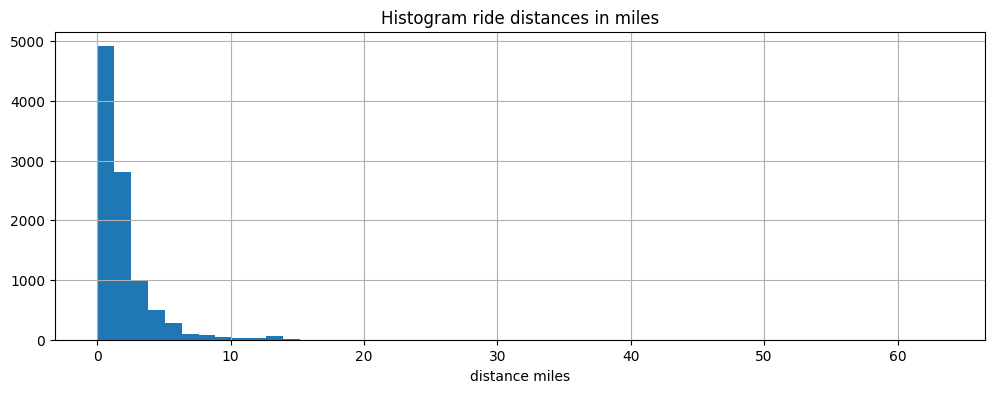

In [37]:
df_train['distance_miles'] = distance(df_train.pickup_latitude, df_train.pickup_longitude, \
                                      df_train.dropoff_latitude, df_train.dropoff_longitude)

df_train.distance_miles.hist(bins=50, figsize=(12,4))
plt.xlabel('distance miles')
plt.title('Histogram ride distances in miles')
df_train.distance_miles.describe()

In [38]:
idx = (df_train.distance_miles >= 0.05)
print('Old size: %d' % len(df_train))
df_train = df_train[idx]
print('New size: %d' % len(df_train))

Old size: 9843
New size: 9646


In [39]:
# df_train.distance_miles.hist(bins=50, figsize=(12,4))
# plt.xlabel('distance miles')
# plt.title('Histogram ride distances in miles')
df_train.distance_miles.describe()

count    9646.000000
mean        1.980811
std         2.425959
min         0.052429
25%         0.773847
50%         1.298509
75%         2.320633
max        63.372442
Name: distance_miles, dtype: float64

In [40]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,hour,distance_miles
0,2009-02-27 13:31:21.0000003,16.5,2009-02-27 13:31:21,-73.974938,40.762091,-74.003309,40.706195,2,2009,4,13,4.137835
1,2009-02-13 16:54:52.0000006,6.7,2009-02-13 16:54:52,-73.959669,40.779718,-73.976259,40.788413,1,2009,4,16,1.055559
3,2009-02-16 07:40:14.0000002,14.5,2009-02-16 07:40:14,-73.948872,40.807601,-73.937218,40.767366,1,2009,0,7,2.846035
4,2009-02-27 17:39:00.000000125,8.1,2009-02-27 17:39:00,-73.992877,40.742668,-73.983468,40.747480,1,2009,4,17,0.594244
5,2009-02-08 10:46:00.00000085,10.9,2009-02-08 10:46:00,-73.998053,40.722607,-73.965630,40.762180,1,2009,6,10,3.218205


In [41]:
# jfk = (-73.7822222222, 40.6441666667)
nyc = (-74.0063889, 40.7141667)

# def plot_location_fare(loc, name, range=1.5):
#     # select all datapoints with dropoff location within range of airport
#     fig, axs = plt.subplots(1, 2, figsize=(14, 5))
#     idx = (distance(df_train.pickup_latitude, df_train.pickup_longitude, loc[1], loc[0]) < range)
#     df_train[idx].fare_amount.hist(bins=100, ax=axs[0])
#     axs[0].set_xlabel('fare $USD')
#     axs[0].set_title('Histogram pickup location within {} miles of {}'.format(range, name))

#     idx = (distance(df_train.dropoff_latitude, df_train.dropoff_longitude, loc[1], loc[0]) < range)
#     df_train[idx].fare_amount.hist(bins=100, ax=axs[1])
#     axs[1].set_xlabel('fare $USD')
#     axs[1].set_title('Histogram dropoff location within {} miles of {}'.format(range, name));
    
# plot_location_fare(jfk, 'JFK Airport')

In [42]:
# ewr = (-74.175, 40.69) # Newark Liberty International Airport, see https://www.travelmath.com/airport/EWR
# lgr = (-73.87, 40.77) # LaGuardia Airport, see https://www.travelmath.com/airport/LGA
# plot_location_fare(ewr, 'Newark Airport')
# plot_location_fare(lgr, 'LaGuardia Airport')

In [43]:
# df_train['fare_per_mile'] = df_train.fare_amount / df_train.distance_miles
# df_train.fare_per_mile.describe()

In [44]:
df_train['distance_to_center'] = distance(nyc[1], nyc[0], df_train.pickup_latitude, df_train.pickup_longitude)

In [45]:
# df_train['pickup_distance_to_jfk'] = distance(jfk[1], jfk[0], df_train.pickup_latitude, df_train.pickup_longitude)
# df_train['dropoff_distance_to_jfk'] = distance(jfk[1], jfk[0], df_train.dropoff_latitude, df_train.dropoff_longitude)

In [46]:
df_train.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,hour,distance_miles,distance_to_center
0,2009-02-27 13:31:21.0000003,16.5,2009-02-27 13:31:21,-73.974938,40.762091,-74.003309,40.706195,2,2009,4,13,4.137835,3.698026
1,2009-02-13 16:54:52.0000006,6.7,2009-02-13 16:54:52,-73.959669,40.779718,-73.976259,40.788413,1,2009,4,16,1.055559,5.147234


In [47]:
# df_train['pickup_distance_to_ewr'] = distance(ewr[1], ewr[0], df_train.pickup_latitude, df_train.pickup_longitude)
# df_train['dropoff_distance_to_ewr'] = distance(ewr[1], ewr[0], df_train.dropoff_latitude, df_train.dropoff_longitude)
# df_train['pickup_distance_to_lgr'] = distance(lgr[1], lgr[0], df_train.pickup_latitude, df_train.pickup_longitude)
# df_train['dropoff_distance_to_lgr'] = distance(lgr[1], lgr[0], df_train.dropoff_latitude, df_train.dropoff_longitude)

In [48]:
df_train.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,hour,distance_miles,distance_to_center
0,2009-02-27 13:31:21.0000003,16.5,2009-02-27 13:31:21,-73.974938,40.762091,-74.003309,40.706195,2,2009,4,13,4.137835,3.698026
1,2009-02-13 16:54:52.0000006,6.7,2009-02-13 16:54:52,-73.959669,40.779718,-73.976259,40.788413,1,2009,4,16,1.055559,5.147234


In [49]:
# df_train['delta_lon'] = df_train.pickup_longitude - df_train.dropoff_longitude
# df_train['delta_lat'] = df_train.pickup_latitude - df_train.dropoff_latitude

# # Select trips in Manhattan
# BB_manhattan = (-74.025, -73.925, 40.7, 40.8)
# idx_manhattan = select_within_boundingbox(df_train, BB_manhattan)

# plt.figure(figsize=(14,8))
# plt.scatter(df_train[idx_manhattan].delta_lon, df_train[idx_manhattan].delta_lat, s=0.5, alpha=1.0, 
#             c=np.log1p(df_train[idx_manhattan].fare_amount), cmap='magma')
# plt.colorbar()
# plt.xlabel('pickup_longitude - dropoff_longitude')
# plt.ylabel('pickup_latitude - dropoff_latidue')
# plt.title('log1p(fare_amount)');

In [50]:
idx = (df_train.distance_to_center<15) & (df_train.passenger_count!=0)
print('Old size: %d' % len(df_train))
df_train = df_train[idx]
print('New size: %d' % len(df_train))

Old size: 9646
New size: 9636


In [51]:
df_test['distance_miles'] = distance(df_test.pickup_latitude, df_test.pickup_longitude, \
                                     df_test.dropoff_latitude, df_test.dropoff_longitude)
df_test['distance_to_center'] = distance(nyc[1], nyc[0], \
                                          df_test.dropoff_latitude, df_test.dropoff_longitude)
df_test['hour'] = df_test.pickup_datetime.apply(lambda t: pd.to_datetime(t).hour)
df_test['year'] = df_test.pickup_datetime.apply(lambda t: pd.to_datetime(t).year)

In [52]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 9914 non-null   object        
 1   pickup_datetime     9914 non-null   datetime64[ns]
 2   pickup_longitude    9914 non-null   float64       
 3   pickup_latitude     9914 non-null   float64       
 4   dropoff_longitude   9914 non-null   float64       
 5   dropoff_latitude    9914 non-null   float64       
 6   passenger_count     9914 non-null   int64         
 7   distance_miles      9914 non-null   float64       
 8   distance_to_center  9914 non-null   float64       
 9   hour                9914 non-null   int64         
 10  year                9914 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(3), object(1)
memory usage: 852.1+ KB


In [53]:
df_test.head(2)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_miles,distance_to_center,hour,year
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,1.443607,2.431036,13,2015
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,1.507044,1.773728,13,2015


In [54]:
df_train.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,hour,distance_miles,distance_to_center
0,2009-02-27 13:31:21.0000003,16.5,2009-02-27 13:31:21,-73.974938,40.762091,-74.003309,40.706195,2,2009,4,13,4.137835,3.698026
1,2009-02-13 16:54:52.0000006,6.7,2009-02-13 16:54:52,-73.959669,40.779718,-73.976259,40.788413,1,2009,4,16,1.055559,5.147234


In [2]:
df_train.to_csv('s3://team07-data/SPARK-ETL/pyspark_ETL_2.csv', index=False)

NameError: name 'df_train' is not defined